In [2]:
#################################################################################################
#####################  Assignment 3 MSDS 458 - Analyze AG_News ##################################
#########################      AUthor: Siyuan Liu      ##########################################
##########################   Date: 2022/2/14   ##################################################
#################################################################################################

In [3]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [4]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


### Functions For Research Assignment 

In [7]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [8]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [9]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Loading AG TensorFlow Dataset

In [10]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2022-02-21 01:06:02.897991: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0221 01:06:02.898276 139915481446272 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0221 01:06:03.050431 139915481446272 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
I0221 01:06:03.215208 139915481446272 dataset_info.py:361] Load dataset info from /tmp/tmp_whbm4n6tfds
I0221 01:06:03.217279 139915481446272 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0221 01:06:03.217718 139915481446272 dataset_builder.py:357] Generating dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0221 01:06:03.483439 139915481446272 download_manager.py:476] 

###  Exploratory Analysis AG News Subset

In [11]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [12]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [13]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [14]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [15]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

### Preprocessing Data Create Input Pipeline

In [16]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-21 01:07:09.581989: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0221 01:07:09.582277 140498551170944 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0221 01:07:09.583372 140498551170944 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0221 01:07:09.584879 140498551170944 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0221 01:07:09.585147 140498551170944 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is 

In [17]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [18]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

In [19]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


In [20]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [22]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
for example, label in train_dataset.take(2): #take() Creates a Dataset with at most count elements from this dataset, so it returns the data elements (since it's been batched/bundled 64 instances per element)
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'French environmentalists condemn hunters who shot one of the last female brown bears in the Pyrenees.'
 b"AP - Jared Zabransky passed for 244 yards and three touchdowns to lead No. 10 Boise State past Nevada 58-21 Saturday night and keep the unbeaten Broncos' hopes alive for a spot in the Bowl Championship Series with their 22nd straight win."
 b"XM Satellite's recruitment of well-known personalities, including Bob Edwards, has been the most aggressive effort to date to win listeners."]

labels:  [3 1 3]
texts:  [b'AP - The race was close, tough, sometimes bitter, but "now\'s the time for healing," President Bush said in sparing the lives of two White House turkeys.'
 b'Reuters - Powerful regional Afghan commander Ismail\\Khan was effectively dismissed as governor of Herat city\\Saturday and declined a promotion to the cabinet of President\\Hamid Karzai.'
 b'Microsoft Corp. has found an unlikely new partner to help promote Windows XP: Google Inc.']

labels:  [0 0 3]


# **Experiment D - Testify Variants of CNN**

## Create the Text Encoder

1. tweek the vocabulary size of encoder
2. Vocabulary customization
3. output sequence length

In [24]:
#from the experiment A, we have identified the encoder with 3000 vocab size, unedited vocabulary, and arbitriy 128 output sequence yield the best result

# encoder 1 - 3000 vocabulary size, no edit of vocabulary, default output sequence length
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=3000, output_sequence_length=128)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [25]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

3000

In [26]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it',
       'has', 'new', 'an', 'from', 'his', 'us', 'will', 'was', 'reuters',
       'after', 'have', 'be', 'their', 'are', 'over', 'ap', 'he', 'but',
       'two', 'first', 'this', 'more', 'monday', 'wednesday', 'tuesday',
       'thursday', 'company', 'up', 'friday', 'inc', 'one', 'world',
       'yesterday', 'they', 'last', 'york', 'against', 'than', 'about',
       'who', 'not', 'were', 'into', 'year', 'been', 'out', 'president',
       'had', 'when', 'million', 'oil', 'corp', 'united', 'sunday',
       'would', 'which', 'week', 'years', 'today', 'three', 'people',
       'government', 'could', 'quot', 'group', 'no', 'time', 'game',
       'percent', 'saturday', 'software', 'night', 'or', 'iraq', 'prices',
       'next', 'security', 'minister', 'announced', 'some'], dtype='<U21')

Here are the 20 least frequent words.

In [27]:
vocab[-20:]

array(['barely', 'bar', 'xbox', 'teammate', 'silver', 'secondquarter',
       'referendum', 'quality', 'population', 'plenty', 'palm',
       'operators', 'memphis', 'materials', 'language', 'landing',
       'homeland', 'friendly', 'firsthalf', 'fed'], dtype='<U21')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [28]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  35,    2,  505,   27,  409, 1539,    1, 2670,   37,    1,    2,
          86,    9,    1,   66,  184,   17,    6,    1,    2, 2210,    5,
          38,  679,  467,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  28,  791, 1725, 1096, 2888,    1,   27,    1, 2351,   14, 2441,
           5,    1,    1,    7, 1870,    3,    1,    4,    2,

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [29]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'AP - The race was close, tough, sometimes bitter, but "now\'s the time for healing," President Bush said in sparing the lives of two White House turkeys.'
Round-trip:  ap the race was close tough [UNK] bitter but [UNK] the time for [UNK] president bush said in [UNK] the lives of two white house [UNK]                                                                                                      

Original:  b'Reuters - Powerful regional Afghan commander Ismail\\Khan was effectively dismissed as governor of Herat city\\Saturday and declined a promotion to the cabinet of President\\Hamid Karzai.'
Round-trip:  reuters powerful regional afghan commander [UNK] was [UNK] dismissed as governor of [UNK] [UNK] and declined a [UNK] to the cabinet of [UNK] karzai                                                                                                        

Original:  b'Microsoft Corp. has found an unlikely new partner to help promote Windows XP: Google Inc.'
Round-trip

## Create the Model based on same encoder but variant model structure

In [30]:
#one single layer LSTM

In [31]:
num_classes = 4
model1 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu') #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid")
                              ,tf.keras.layers.Flatten()
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

## Compile Model 

In [32]:
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [33]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 64)           192000    
                                                                 
 conv1d (Conv1D)             (None, 128, 64)           32832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 127, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8128)              0         
                                                                 
 dense (Dense)               (None, 64)                5

## Model Trainning

In [34]:
history1 = model1.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 71s 39ms/step - loss: 0.6200 - accuracy: 0.7538 - val_loss: 0.3699 - val_accuracy: 0.8735
Epoch 2/200
1782/1782 [==============================] - 74s 41ms/step - loss: 0.3340 - accuracy: 0.8833 - val_loss: 0.3311 - val_accuracy: 0.8850
Epoch 3/200
1782/1782 [==============================] - 70s 39ms/step - loss: 0.2977 - accuracy: 0.8951 - val_loss: 0.3191 - val_accuracy: 0.8877
Epoch 4/200
1782/1782 [==============================] - 69s 39ms/step - loss: 0.2775 - accuracy: 0.9022 - val_loss: 0.3124 - val_accuracy: 0.8903
Epoch 5/200
1782/1782 [==============================] - 70s 39ms/step - loss: 0.2643 - accuracy: 0.9060 - val_loss: 0.3109 - val_accuracy: 0.8902
Epoch 6/200
1782/1782 [==============================] - 70s 39ms/step - loss: 0.2535 - accuracy: 0.9090 - val_loss: 0.3088 - val_accuracy: 0.8902


In [35]:
test_loss, test_acc = model1.evaluate(test_dataset)

119/119 [==============================] - 2s 14ms/step - loss: 0.3147 - accuracy: 0.8883


In [36]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.620,0.754,0.370,0.873
1,0.334,0.883,0.331,0.885
2,0.298,0.895,0.319,0.888
3,0.278,0.902,0.312,0.890
4,0.264,0.906,0.311,0.890
5,0.254,0.909,0.309,0.890


In [38]:
losses = history1.history['loss']
accs = history1.history['accuracy']
val_losses = history1.history['val_loss']
val_accs = history1.history['val_accuracy']
epochs = len(losses)

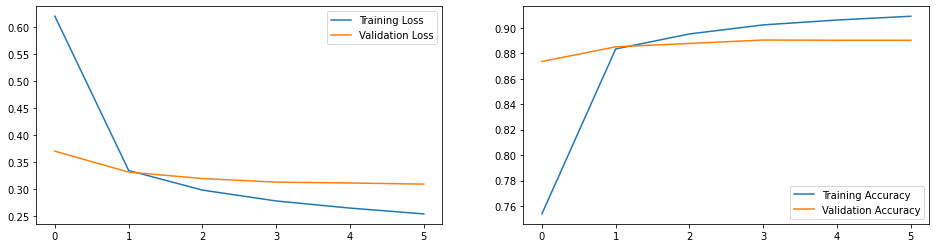

In [39]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [40]:
# track the test performance
test_accuracy = []
test_accuracy.append(test_acc)

In [ ]:
## create model with one bidirection LSTM

In [44]:
num_classes = 4
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu') #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid")
                              ,tf.keras.layers.Dropout(0.3)
                              ,tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu') #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid")
                              ,tf.keras.layers.Dropout(0.3)
                              ,tf.keras.layers.Flatten()
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [45]:
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [46]:
history2 = model2.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 141s 78ms/step - loss: 0.6146 - accuracy: 0.7487 - val_loss: 0.3664 - val_accuracy: 0.8737
Epoch 2/200
1782/1782 [==============================] - 139s 78ms/step - loss: 0.3493 - accuracy: 0.8777 - val_loss: 0.3396 - val_accuracy: 0.8805
Epoch 3/200
1782/1782 [==============================] - 139s 78ms/step - loss: 0.3106 - accuracy: 0.8909 - val_loss: 0.3174 - val_accuracy: 0.8855
Epoch 4/200
1782/1782 [==============================] - 140s 78ms/step - loss: 0.2881 - accuracy: 0.8986 - val_loss: 0.3169 - val_accuracy: 0.8845
Epoch 5/200
1782/1782 [==============================] - 138s 77ms/step - loss: 0.2737 - accuracy: 0.9034 - val_loss: 0.3056 - val_accuracy: 0.8918
Epoch 6/200
1782/1782 [==============================] - 138s 78ms/step - loss: 0.2622 - accuracy: 0.9070 - val_loss: 0.3091 - val_accuracy: 0.8900
Epoch 7/200
1782/1782 [==============================] - 140s 78ms/step - loss: 0.2524 - accuracy: 0.9103 - val_

In [47]:
test_loss, test_acc = model2.evaluate(test_dataset)

119/119 [==============================] - 2s 20ms/step - loss: 0.3139 - accuracy: 0.8907


In [48]:
history_dict = history2.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.615,0.749,0.366,0.874
1,0.349,0.878,0.340,0.881
2,0.311,0.891,0.317,0.886
3,0.288,0.899,0.317,0.885
4,0.274,0.903,0.306,0.892
5,0.262,0.907,0.309,0.890
6,0.252,0.910,0.303,0.894
7,0.244,0.913,0.308,0.889
8,0.234,0.916,0.308,0.891


In [50]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

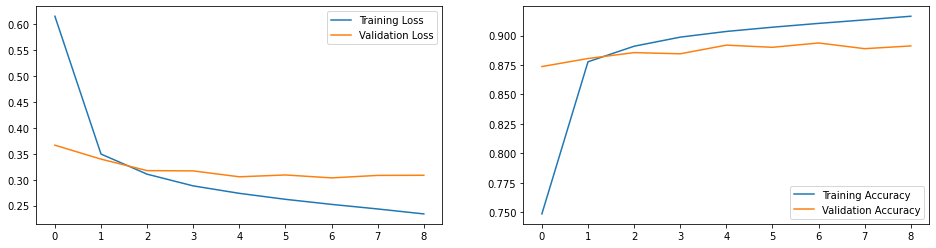

In [51]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [52]:
# track the test performance
test_accuracy.append(test_acc)

In [53]:
model_name =['model1','model2']
model_descr =['1 CNN (64), 1 MaxPooling, 1 DNN (64)',
              '2 CNN (64, 128), 2 MaxPooling, 2 Droput (0.3), 1 DNN (64)',
             ]

In [54]:
perf_dict = { 'model' : model_name,
              'description': model_descr,
              'test_accuracy': test_accuracy
}

df_perf = pd.DataFrame(perf_dict)
print(df_perf)

    model                                        description  test_accuracy
0  model1               1 CNN (64), 1 MaxPooling, 1 DNN (64)       0.888289
1  model2  2 CNN (64, 128), 2 MaxPooling, 2 Droput (0.3),...       0.890658


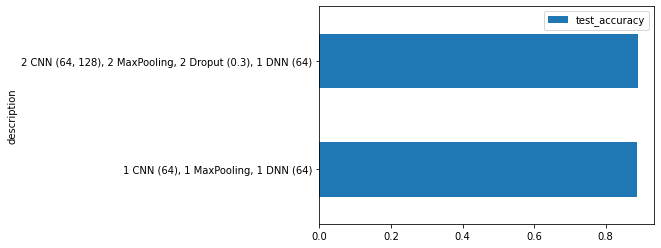

In [55]:
df_perf.plot.barh(x='description', y='test_accuracy')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/458_AI/Assignment3/Liu_Assignment3_Part3_LSTM.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/458_AI/Assignment3/Liu_Assignment3_Part3_LSTM.ipynb to html
[NbConvertApp] Writing 746694 bytes to /content/gdrive/MyDrive/458_AI/Assignment3/Liu_Assignment3_Part3_LSTM.html
